## Cleaning Data

In [1]:
import wfdb
import mne
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
import os 

import argparse
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import sys
import numpy as np
import torch.nn.functional as F
from scipy.io import loadmat
import torch
import biosppy

from pprint import pprint

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

from torchsummary import summary

In [4]:
from pyedflib import highlevel
import pyedflib as plib

f = plib.EdfReader("Capstone/ISRUC/s1/1/1.rec")

OSError: Capstone/ISRUC/s1/1/1.rec: a read error occurred

In [8]:
import rarfile
path = "Capstone/ISRUC/"

with rarfile.RarFile(path + "1.rar") as rar:
    print(rar.namelist())
    rar.extract('1/1.rec', path+"s1")

['1/1.rec', '1/1_1.txt', '1/1_1.xlsx', '1/1_2.txt', '1/1_2.xlsx', '1/']


BadRarFile: Failed the read enough data: req=65536 got=62

In [10]:
!pip install 7zip

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement 7zip (from versions: none)
ERROR: No matching distribution found for 7zip


In [9]:
import patoolib
patoolib.extract_archive(path + "1.rar", outdir=path+"s1")

INFO patool: Extracting Capstone/ISRUC/1.rar ...


PatoolError: could not find an executable program to extract format rar; candidates are rar,unrar,7z,7zz,7zzs,unar

In [2]:
from pyedflib import highlevel
import pyedflib as plib

f = plib.EdfReader("Capstone/ISRUC/s1/1/1.rec")

OSError: Capstone/ISRUC/s1/1/1.rec: a read error occurred

In [53]:

import patoolib
path = "Capstone/ISRUC"
for i in range(1,51):
    patoolib.extract_archive(path+f'/{i}.rar', outdir=path+f'/s{i}')


INFO patool: Extracting Capstone/ISRUC/1.rar ...


PatoolError: could not find an executable program to extract format rar; candidates are rar,unrar,7z,7zz,7zzs,unar

In [35]:
%%sh
for ((i=2;i<=50;i++)); do
    mkdir "Capstone/ISRUC/s$i"
done


## OLD DATA

In [2]:
records_names = ['slp01a', 'slp01b', 'slp02a', 'slp01b', 'slp03',
                 'slp04', 'slp14', 'slp16', 'slp32', 'slp37',
                 'slp41', 'slp45', 'slp48', 'slp59', 'slp60', 'slp61',
                 'slp66', 'slp67x'
]

In [3]:
X = []
X_fields = []
y = []

for record in records_names:
    signals, fields = wfdb.rdsamp(f"/sfs/weka/scratch/pcf4ku/Capstone/Capstone/mit_eeg/{record}")
    
    X.append(signals)
    X_fields.append(fields)
    y.append(wfdb.rdann(f"/sfs/weka/scratch/pcf4ku/Capstone/Capstone/mit_eeg/{record}", extension='st').aux_note)


In [5]:
def parse_annot_simple(label):
    apnea = np.intersect1d(label.split(' '), ('OA', 'X', 'CA', 'CAA'))
    return 1 if apnea.size != 0 else 0

labels = [[parse_annot_simple(annot) for  annot in label_list] for label_list in y ]

In [6]:
const = 7500

for i in range(len(X)):
    print(i, f"orig shape { len(X[i])},  num labels {len(labels[i])}, " , end =' ')
    number_epochs = int(len(X[i])/7500)
    starting_index = (number_epochs - len(labels[i]))*const

    X[i] = X[i][starting_index:]

    X[i] = X[i][:, [np.flatnonzero(np.core.defchararray.find(X_fields[0]['sig_name'],'EEG')!=-1)[0]]]
    X[i] *= 1e-3

    X[i] = np.split(X[i], len(labels[i]))
    X[i] = np.rollaxis(np.array(X[i]), 2, 1)
    print(np.array(X[i]).shape)

0 orig shape 1800000,  num labels 240,  (240, 1, 7500)
1 orig shape 2700000,  num labels 360,  (360, 1, 7500)
2 orig shape 2700000,  num labels 360,  (360, 1, 7500)
3 orig shape 2700000,  num labels 360,  (360, 1, 7500)
4 orig shape 5400000,  num labels 720,  (720, 1, 7500)
5 orig shape 5400000,  num labels 720,  (720, 1, 7500)
6 orig shape 5400000,  num labels 714,  (714, 1, 7500)
7 orig shape 5400000,  num labels 694,  (694, 1, 7500)
8 orig shape 4800000,  num labels 640,  (640, 1, 7500)
9 orig shape 5250000,  num labels 698,  (698, 1, 7500)
10 orig shape 5850000,  num labels 780,  (780, 1, 7500)
11 orig shape 5700000,  num labels 760,  (760, 1, 7500)
12 orig shape 5700000,  num labels 760,  (760, 1, 7500)
13 orig shape 3600000,  num labels 458,  (458, 1, 7500)
14 orig shape 5325000,  num labels 710,  (710, 1, 7500)
15 orig shape 5550000,  num labels 720,  (720, 1, 7500)
16 orig shape 3300000,  num labels 439,  (439, 1, 7500)
17 orig shape 1155000,  num labels 154,  (154, 1, 7500)


In [7]:
import numpy as np
from biosppy.signals import tools

# Example initialization, replace with your actual data and sampling rate
# X = [np.array([...]), np.array([...]), ...]
sampling_rate = 250  # Example sampling rate, replace with your actual rate

# Define the frequency band
lowcut = 4.0
highcut = 45.0

filtered_X = []
for patient_data in X:
    filtered, sampl_rate, params = biosppy.signals.tools.filter_signal(signal=patient_data,
                                 ftype='butter',
                                 band='bandpass',
                                 order=4,
                                 frequency=[lowcut, highcut],
                                 sampling_rate=sampling_rate)


    filtered_X.append(filtered)

In [8]:
X_centered_and_normalized = []

for array in filtered_X:
    # Ensure each array is at least 2D (if it's 1D with shape (N,))
    if array.ndim == 1:
        array = array.reshape(-1, 1)

    # Centering
    centered_array = array - np.mean(array, axis=0, keepdims=True)

    # Avoid division by zero in normalization
    norm = np.linalg.norm(centered_array, axis=0, keepdims=True)
    norm[norm == 0] = 1

    # Normalization
    normalized_array = centered_array / norm

    X_centered_and_normalized.append(normalized_array)

In [10]:
X_reduced = np.concatenate(X_centered_and_normalized)
y_reduced = np.concatenate(labels)

print(X_reduced.shape)
print(y_reduced.shape)

(10287, 1, 7500)
(10287,)


In [11]:
from torch.utils.data import random_split, TensorDataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=.2)

#normalize = lambda x: (x - np.mean(x))/  np.std(x)
#X_train = normalize(X_train)
#X_test = normalize(X_test)

X_train.shape

(8229, 1, 7500)

In [12]:
X_train[0]

array([[-0.03887421,  0.09968896,  0.09465107, ..., -0.0732002 ,
        -0.08477293, -0.02261323]])

In [13]:
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32) 
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=32) 

## Parsing Data

NameError: name 'channel_names' is not defined

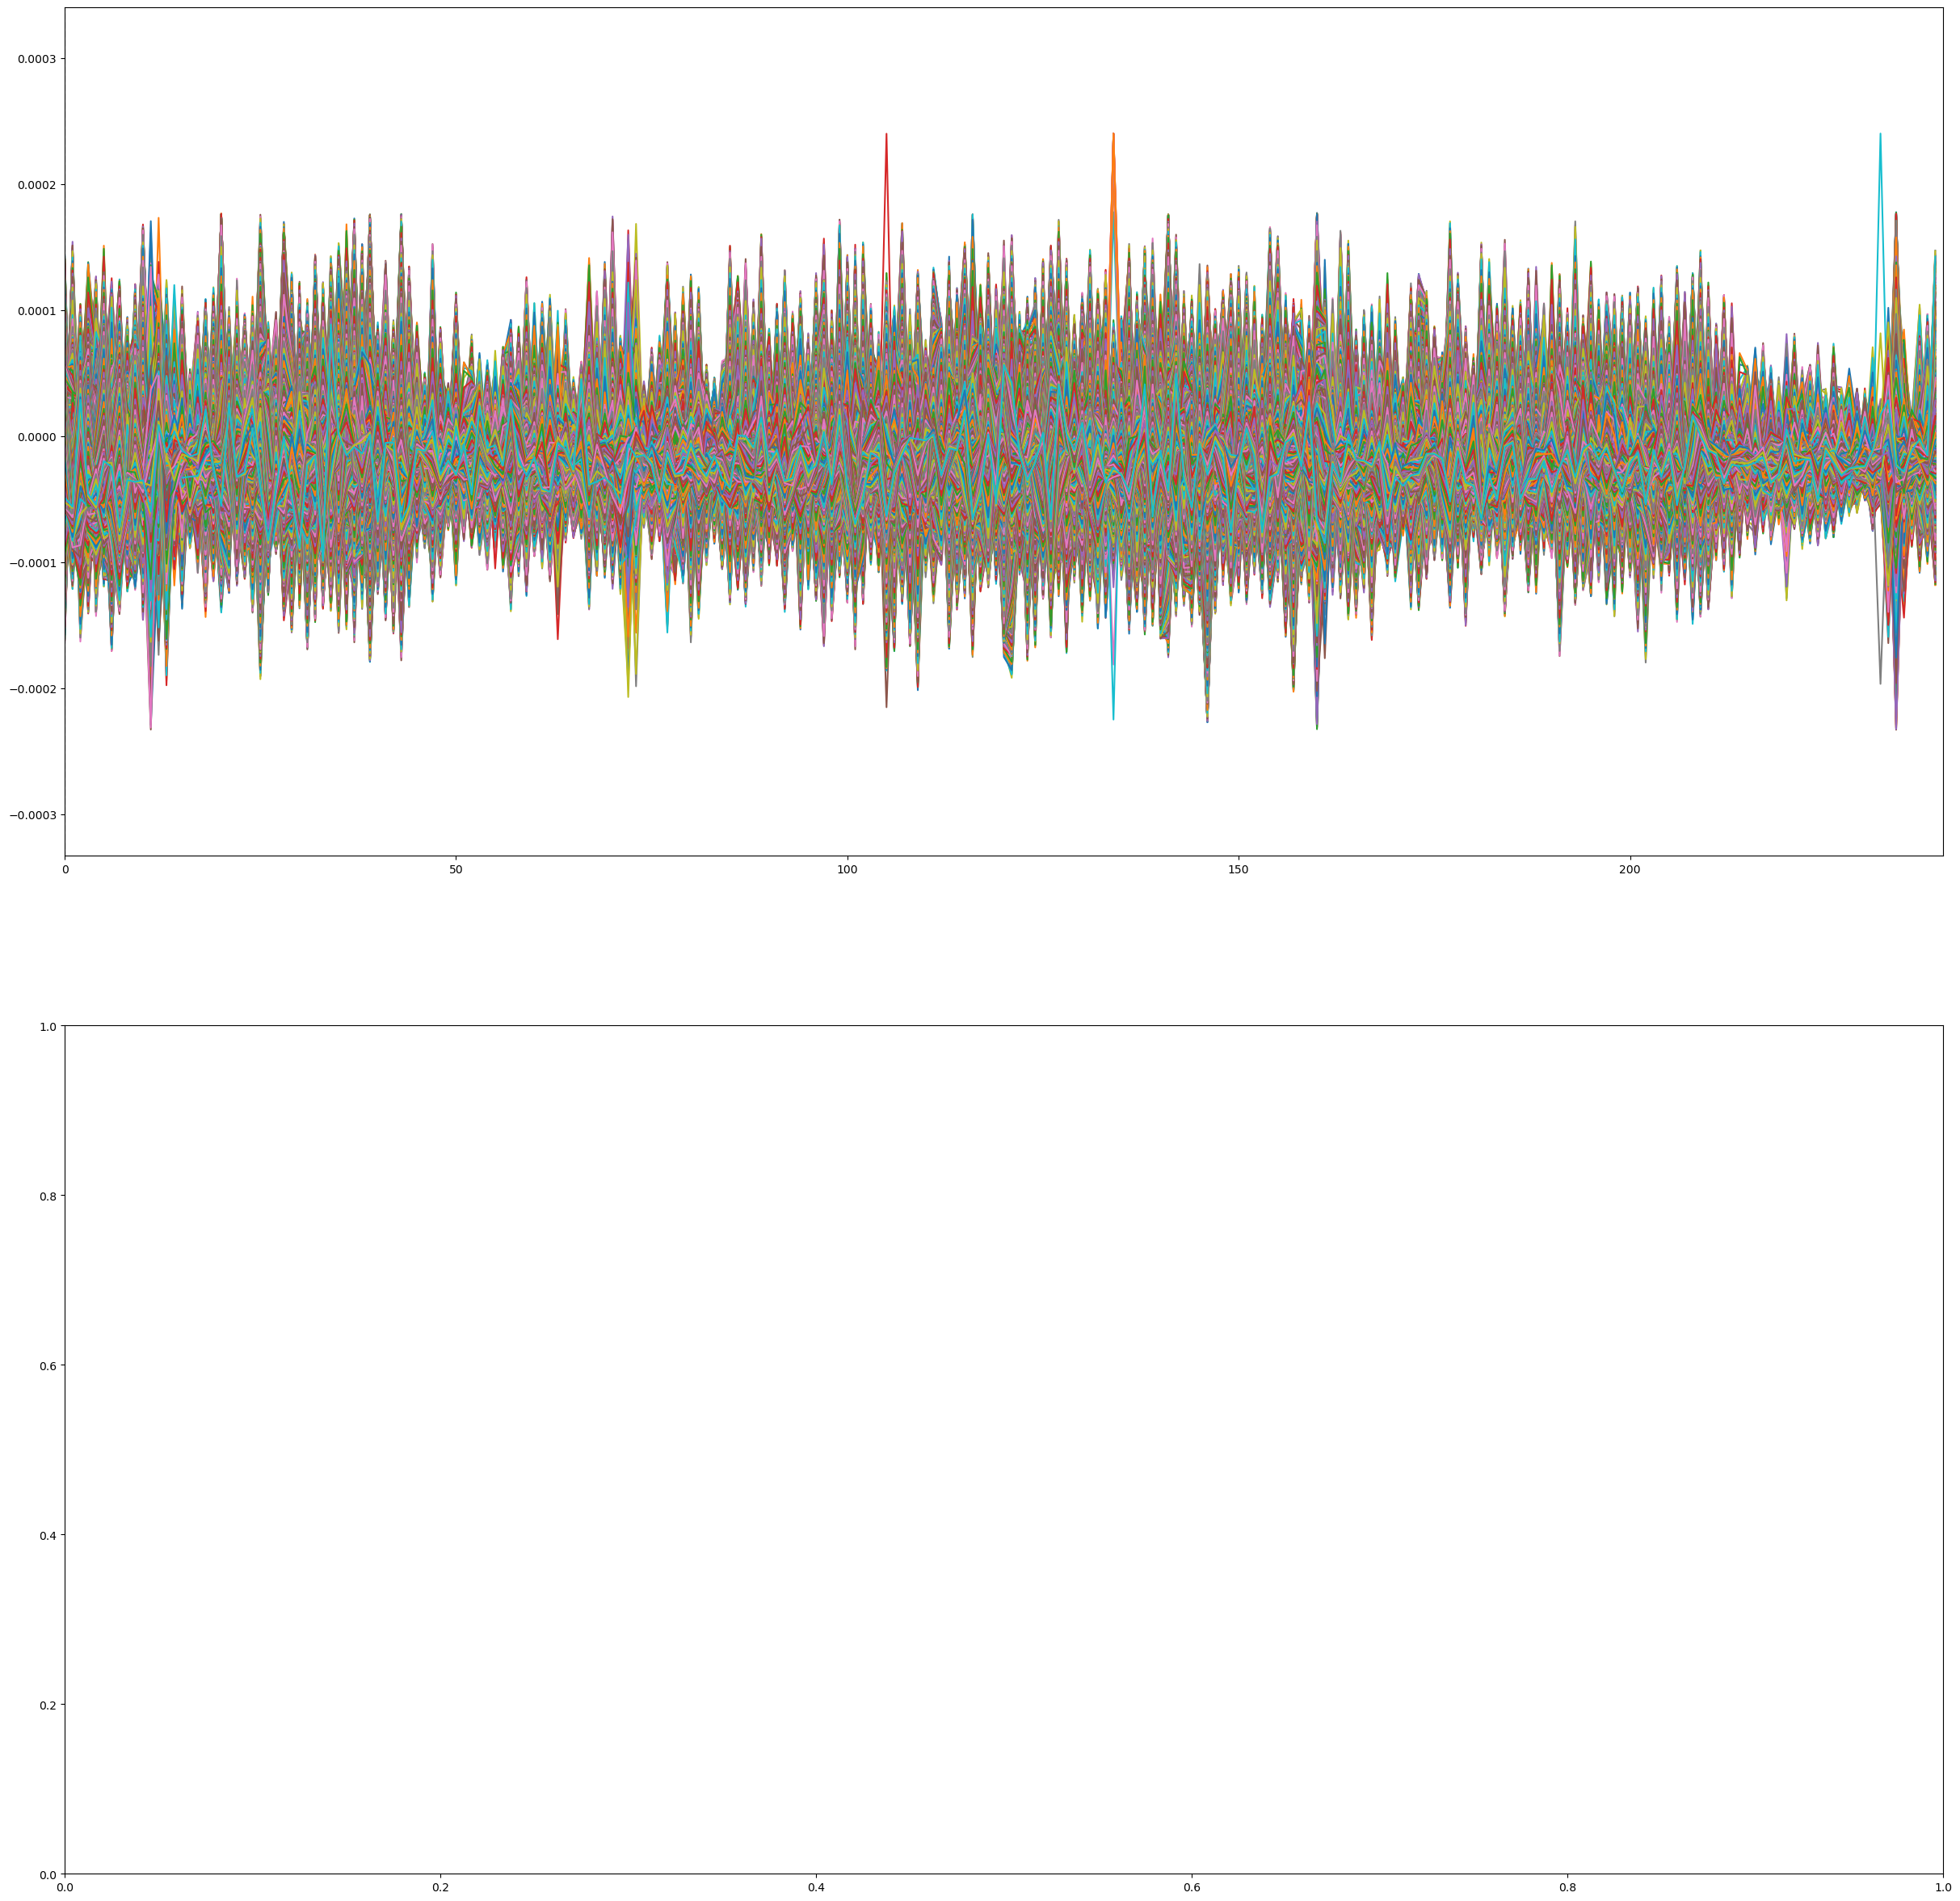

In [7]:
start, end = 0, 15
epoch_size = 75000
signal_sub = X[0][start*epoch_size:end*epoch_size, :]
signal_sub = np.rollaxis(signal_sub,1, 0)

_, axs = plt.subplots(2, 1, figsize=(30, 30))

for signal, ax in zip(signal_sub, axs):

    ax.plot(signal)
    ax.vlines(x=np.arange(0,len(signal), epoch_size),ymin=-40, ymax=40, color='k', ls='--')

    # for i, event in enumerate(labels_sub):
    #   if pd.isna(event):
    #     continue
    #   ax.axvspan(i*resamp_size, (i+1)*resamp_size, alpha=0.5, color=label_colours[event])

    ax.set_ylim(signal.min()-1e-4, signal.max()+1e-4 )
    ax.set_xlim(0, len(signal))

for i, ax in enumerate(axs):
    ax.set_ylabel(channel_names[i])

plt.show()

### Modeling

In [7]:
class RemovePadding1d(nn.Module):
    def __init__(self, pad_size):
        super(RemovePadding1d, self).__init__()
        self.pad_size = pad_size

    def forward(self, x):
        return x[:, :, :-self.pad_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.rpad1 = RemovePadding1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.rpad2 = RemovePadding1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.rpad1, self.relu1, self.dropout1,
                                 self.conv2, self.rpad2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

### OLD

In [8]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [10]:
if torch.cuda.is_available():
    print("WARNING: You have a CUDA device, so you should probably run with cuda")

In [34]:
subject_idx = 6
seq_arr = torch.from_numpy(X[subject_idx])
label_arr = torch.from_numpy(np.array(labels[subject_idx]))

#print(X_train.shape)
print(seq_arr.shape)
print(label_arr.shape)

torch.Size([714, 1, 7500])
torch.Size([714])


In [45]:
channel_sizes = [150]*8
kernel_size = 5
dropout = .25

input_channels = 1
n_classes = 1

epochs_num = 10

model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)



if torch.cuda.is_available():
    model.cuda()
    label_arr = label_arr.cuda()
    seq_arr = seq_arr.cuda()



In [42]:
for i in range(0, seq_arr.size(0)-batch_size, batch_size):
    if i + batch_size > seq_arr.size(0):
        x, y = seq_arr[i:], label_arr[i:]
    else:
        x, y = seq_arr[i:(i+batch_size)], label_arr[i:(i+batch_size)]
    break
x.size()

torch.Size([32, 1, 7500])

In [13]:
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


seqence_len = 1  

def train(epoch, X_t, Y_t, batch_size, window_size=1):
    model.train()
    batch_idx = 1
    total_loss = 0
    
    for i in range(0, X_t.size(0)-batch_size, batch_size):
        if i + batch_size > X_t.size(0):
            x, y = X_t[i:], Y_t[i:]
        else:
            x, y = X_t[i:(i+batch_size)], Y_t[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x.float())
        
        loss = criterion(output.squeeze(), y.float())
        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 10 == 0:
            cur_loss = total_loss / 100
            processed = min(i+batch_size, X_t.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_t.size(0), 100.*processed/X_t.size(0), lr, cur_loss))
            total_loss = 0


In [38]:
def train_loop_original(X_t, Y_t, batch_size, model, loss_fn, optimizer, calculating_accuracy=True):
    #print(model)
    model.train()
    size = X_t.size(0)
    losses_train = []
    steps = []
    if calculating_accuracy:
        accuracies_epoch = []
        
    for batch, i in enumerate(range(0, size, batch_size)):
    #for batch, (X, y) in enumerate(dataloader):
        # Move data from the CPU to the GPU
        #X = X.to(device, non_blocking=True)
        #y = y.to(device, non_blocking=True)
        if i + batch_size > size:
            x, y = X_t[i:], Y_t[i:]
        else:
            x, y = X_t[i:(i+batch_size)], Y_t[i:(i+batch_size)]

        # Compute prediction and loss (forward pass)
        pred = model(x.float())
        print(f'pred{pred.squeeze()}\n y {y.float()}')
        loss = loss_fn(pred.squeeze(), y.float())
        print(f'loss {loss}')
        return
        # Backpropagation (backward pass)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        current = batch * len(x)

        loss = loss.item()
        if batch % 10 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses_train.append(loss)
        steps.append(current)
        # Compute accuracy without affecting the gradients

        if calculating_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculating_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

train_loop = train_loop_original

In [42]:
for i in range(1):
    print(f'Epoch {i}\n----------------------------')
    train_loop(seq_arr, label_arr, 5, model, criterion, optimizer)
    print()

Epoch 0
----------------------------
predtensor([-0.0716, -0.0689, -0.0727, -0.0731, -0.0763], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
 y tensor([0., 0., 0., 0., 0.], device='cuda:0')
loss -0.0



In [34]:
pred = [-0.0655, -0.0849, -0.1261, -0.0688, -0.1204]
true  = [0,0,0,0,0]

loss = 0
     
# Doing cross entropy Loss
for i in range(len(pred)):

    # Here, the loss is computed using the
    # above mathematical formulation.
    loss = loss + (-1 * true[i]*np.log(pred[i]))

loss

/tmp/ipykernel_416919/3591043738.py:11: RuntimeWarning: invalid value encountered in log
  loss = loss + (-1 * true[i]*np.log(pred[i]))


In [ ]:
[-0.0655, -0.0849, -0.1261, -0.0688, -0.1204]

In [13]:
test_subject_idx = 6
test_seq_arr = torch.from_numpy(X[test_subject_idx])
test_label_arr = torch.from_numpy(np.array(labels[test_subject_idx]))

print(test_seq_arr.shape)
print(test_label_arr.shape)

torch.Size([714, 1, 7500])
torch.Size([714])


In [14]:
test_batch = test_seq_arr[29:34]
test_batch_labels = test_label_arr[29:34]
test_batch.shape

torch.Size([5, 1, 7500])

In [15]:
pred = model(test_batch.float())
print("labels", test_batch_labels)
print("preds", pred)

labels tensor([0, 0, 0, 0, 1])
preds tensor([[-0.6404],
        [-0.6554],
        [-0.5805],
        [-0.6118],
        [-0.5776]], grad_fn=<AddmmBackward0>)


In [60]:
def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

tensor([[0.4718],
        [0.4587],
        [0.4606],
        [0.4774],
        [0.4592]], grad_fn=<AddmmBackward0>)

In [ ]:
for i in range(len(labels)):
    

Identical Code Test

In [6]:
import torch
import numpy as np
from torch.autograd import Variable


def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in range(N):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

In [60]:
import torch
import argparse
import torch.optim as optim
import torch.nn.functional as F

#from TCN.adding_problem.model import TCN
#from TCN.adding_problem.utils import data_generator


torch.manual_seed(123)

input_channels = 2
n_classes = 1
batch_size = 32
seq_length = 400
epochs = 30


print("Producing data...")
X_train, Y_train = data_generator(5000, seq_length)
X_test, Y_test = data_generator(5, seq_length)


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [30]*8
kernel_size = 3
dropout = 0.1
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if torch.cuda.is_available():
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = 1e-3
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

Producing data...


In [61]:
X_train.size()

torch.Size([5000, 2, 400])

In [63]:
model.train()
for i in range(0, X_train.size(0), batch_size):
    if i + batch_size > X_train.size(0):
        x, y = X_train[i:], Y_train[i:]
    else:
        x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
    optimizer.zero_grad()
    output = model(x)
    break
    

In [64]:
x.size()

torch.Size([32, 2, 400])

In [65]:
model(x).size()

torch.Size([32, 1])

In [32]:
nn.MSELoss(output, y)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [27]:
(x1, x2) = x[0].to('cpu').numpy()

np.dot(x1, x2)

1.2350011

In [ ]:
def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

In [ ]:
batch_size=1024
sequence_length=32
# input image dimensions
pos_indices = np.random.choice(batch_size, size=int(batch_size // 2), replace=False)

x_train = np.zeros(shape=(batch_size, sequence_length))
print(f"X_train shape: {x_train.shape}")
y_train = np.zeros(shape=(batch_size, 1))
print(f"y_train shape:{y_train.shape}")
x_train[pos_indices, 0] = 1.0
y_train[pos_indices, 0] = 1.0

X_train shape: (1024, 32)
y_train shape:(1024, 1)


# START FROM HERE STUPID

In [59]:
class TCN(nn.Module):

    def __init__(self, input_size, output_size, num_channels,
                 kernel_size=2, dropout=0.3, emb_dropout=0.1, tied_weights=False):
        super(TCN, self).__init__()
#         self.encoder = nn.Embedding(output_size, input_size)
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)

#         self.decoder = nn.Linear(num_channels[-1], output_size)
#         if tied_weights:
#             if num_channels[-1] != input_size:
#                 raise ValueError('When using the tied flag, nhid must be equal to emsize')
#             self.decoder.weight = self.encoder.weight
#             print("Weight tied")
#         self.drop = nn.Dropout(emb_dropout)
#         self.emb_dropout = emb_dropout
#         self.init_weights()

#     def init_weights(self):
#         self.encoder.weight.data.normal_(0, 0.01)
#         self.decoder.bias.data.fill_(0)
#         self.decoder.weight.data.normal_(0, 0.01)

    def forward(self, input):
        """Input ought to have dimension (N, C_in, L_in), where L_in is the seq_len; here the input is (N, L, C)"""
        #emb = self.drop(self.encoder(input))
        #print(emb.size())
        y = self.tcn(input.transpose(1, 2)).transpose(1, 2)
        #y = self.decoder(y)
        return y.contiguous()

In [78]:
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        print(y1)
        return self.linear(y1[:, :, -1])

In [31]:
seq_arr_test = np.rollaxis(X[5], 2, 0)
label_arr_test =  np.array(labels[5])
#seq_arr_test = np.rollaxis(X[5], 1, 0)
print(seq_arr_test.shape)
print(label_arr_test.shape)

(7500, 720, 1)
(720,)


In [62]:

emsize = 1
n_classes = 1
num_chans = [500] * (8 - 1) + [emsize]
k_size = 3
dropout = .1
emb_dropout = .1
tied = False

model = TCN(emsize, n_classes, num_chans, dropout=dropout, 
            emb_dropout=emb_dropout, kernel_size=k_size, tied_weights=tied)

lr = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

if torch.cuda.is_available():
    model.cuda()
    label_arr = torch.from_numpy(label_arr_test).cuda()
    seq_arr = torch.from_numpy(seq_arr_test).cuda()

In [37]:
def get_batch(source, i, seq_len, evaluation=False):
    seq_len_n = min(seq_len, source.size(1) - 1 - i)
    print(seq_len_n)
    data = Variable(source[:, i:i+seq_len_n], volatile=evaluation)
    target = Variable(source[:, i+1:i+1+seq_len_n])  # CAUTION: This is un-flattened!
    return data, target

In [63]:
import time 
model.train()
total_loss = 0
start_time = time.time()

valid_seq_len = 1
seq_len = 5

for babatch_idxtch, i in enumerate(range(0, seq_arr.size(1) - 1, valid_seq_len)):
    if i + seq_len - valid_seq_len >= seq_arr.size(1) - 1:
        continue
    print(babatch_idxtch, i, seq_len)
    data, targets = get_batch(seq_arr, i, seq_len)
    optimizer.zero_grad()
    #data=data.transpose(0,1).transpose(1,2)
    #targets=targets.transpose(0,1).transpose(1,2)
    output = model(data.float())
    
    break
    # if babatch_idxtch == 2:
    #     break

    # eff_history = seq_len - valid_seq_len
    # if eff_history < 0:
    #     raise ValueError("Valid sequence length must be smaller than sequence length!")
    # final_target = targets[:, eff_history:].contiguous().view(-1)
    # final_output = output[:, eff_history:].contiguous().view(-1, n_words)
    # loss = criterion(final_output, final_target)
    # loss.backward()

0 0 5
5


In [69]:
output.size()

eff_history = seq_len - valid_seq_len
final_output = output[:, eff_history].contiguous().view(-1, 1)

In [70]:
final_output.size()

torch.Size([7500, 1])

In [72]:
final_target = targets[:, eff_history:].contiguous().view(-1)
final_target.shape

torch.Size([7500])

In [ ]:
for i

# Even More Modeling

In [25]:
import torch
import torch.nn as nn

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
     
    

# class TCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(TCN, self).__init__()
#         self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
#         self.linear = nn.Linear(num_channels[-1], output_size)
#         self.init_weights()

#     def init_weights(self):
#         self.linear.weight.data.normal_(0, 0.01)

#     def forward(self, x):
#         y1 = self.tcn(x)
#         return self.linear(y1[:, :, -1])
#         return self.sig(output)

In [8]:
def train_loop_original(X_t, Y_t, batch_size, model, loss_fn, optimizer, calculating_accuracy=True):
    #print(model)
    model.train()
    size = X_t.size(0)
    losses_train = []
    steps = []
    if calculating_accuracy:
        accuracies_epoch = []
        
    for batch, i in enumerate(range(0, size, batch_size)):
        if i + batch_size > size:
            x, y = X_t[i:], Y_t[i:]
        else:
            x, y = X_t[i:(i+batch_size)], Y_t[i:(i+batch_size)]
        # Compute prediction and loss (forward pass)
        pred = model(x.float())
        print(pred.squeeze())
        print(y)
        loss = loss_fn(pred.squeeze(), y.float())
        # Backpropagation (backward pass)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        return
        current = batch * len(x)

        loss = loss.item()
        if batch % 10 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses_train.append(loss)
        steps.append(current)
        # Compute accuracy without affecting the gradients

        if calculating_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculating_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

train_loop = train_loop_original

In [21]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [23]:
subject_idx = 6
seq_arr = torch.from_numpy(X[subject_idx])
label_arr = torch.from_numpy(np.array(labels[subject_idx]))

#print(X_train.shape)
print(seq_arr.shape)
print(label_arr.shape)

if not torch.cuda.is_available():
    model.cuda()
    label_arr = label_arr.cuda()
    seq_arr = seq_arr.cuda()


torch.Size([714, 1, 7500])
torch.Size([714])


In [19]:
torch.cuda.is_available()

True

In [25]:
criterion = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [26]:
for i in range(10):
    print(f'Epoch {i}\n----------------------------')
    train_loop(seq_arr,
               label_arr,
               5, 
               model, 
               criterion, 
               optimizer)
    print()

Epoch 0
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 1
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 2
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 3
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 4
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 5
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 6
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 7
----------------------------
tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0, 0, 0, 0, 0])

Epoch 8
----------------------------
tensor([1.,

KeyboardInterrupt: 

# Final One

In [14]:
class RemovePadding1d(nn.Module):
    def __init__(self, pad_size):
        super(RemovePadding1d, self).__init__()
        self.pad_size = pad_size

    def forward(self, x):
        return x[:, :, :-self.pad_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.rpad1 = RemovePadding1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.rpad2 = RemovePadding1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.rpad1, self.relu1, self.dropout1,
                                 self.conv2, self.rpad2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [15]:
## LSTM_CRF
from torchsummary import summary
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [16]:
class TCN(nn.Module):
    def __init__(self, nb_classes, n_channels, n_samples, F1, F2, D, kernel_size, dropout):
        super(TCN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, kernel_size), padding='same', bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1*D, kernel_size=n_channels, padding='valid', groups=F1, bias=False),
            nn.BatchNorm2d(F1*D),
            nn.ELU(),
            nn.AvgPool2d((4,1)),
            nn.Dropout(dropout),
        )

        self.block2 = nn.Sequential(
            SeparableConv2d(F1*D, F2, kernel_size=(1,int(250/8)), padding='same', bias=False),
             #nn.Conv2d(F1*D, F2, kernel_size=(1, int(250/8)), padding='same', bias=False),
             nn.BatchNorm2d(F2),
             nn.ELU(),
             nn.AvgPool2d((8,1)),
             nn.Dropout(dropout)
         )

        #self.tcn = TCN()
        self.channel_sizes = [150]*8
        self.tcn_kernel_size = 5
        self.tcn_dropout = .25

        self.tcn = TemporalConvNet(F2, self.channel_sizes, kernel_size=self.tcn_kernel_size, dropout=self.tcn_dropout)
        #self.tcn = TCNBlock(F2, 3, 3, kernel_size, self.tcn_dropout, activation='relu')
        self.linear = nn.Linear(35100, nb_classes)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x[:,:,:,-1]
        x = self.tcn(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x #torch.sigmoid(x)


sfreq = 250
n_channels = 1
n_classes = 1
n_epochs = 1
time_per_epoch = 30

depth_multiplier = 2
kernel_size = int(sfreq/2)
dropout = 0.2

model = TCN(n_classes
            ,n_channels
            ,sfreq*time_per_epoch*n_epochs
            ,int(sfreq/2)
            ,int(sfreq/2)*depth_multiplier
            ,depth_multiplier 
            ,kernel_size 
            ,dropout)

input_shape = (1, sfreq*time_per_epoch*n_epochs, n_channels)
print(input_shape)

summ = summary(model, 
               input_shape,
               device='cpu',
               col_names=["input_size","output_size",],
               verbose=0)
print(str(summ))

/home/pcf4ku/.local/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


(1, 7500, 1)
Layer (type:depth-idx)                        Input Shape               Output Shape
├─Sequential: 1-1                             [-1, 1, 7500, 1]          [-1, 250, 1875, 1]
|    └─Conv2d: 2-1                            [-1, 1, 7500, 1]          [-1, 125, 7500, 1]
|    └─BatchNorm2d: 2-2                       [-1, 125, 7500, 1]        [-1, 125, 7500, 1]
|    └─Conv2d: 2-3                            [-1, 125, 7500, 1]        [-1, 250, 7500, 1]
|    └─BatchNorm2d: 2-4                       [-1, 250, 7500, 1]        [-1, 250, 7500, 1]
|    └─ELU: 2-5                               [-1, 250, 7500, 1]        [-1, 250, 7500, 1]
|    └─AvgPool2d: 2-6                         [-1, 250, 7500, 1]        [-1, 250, 1875, 1]
|    └─Dropout: 2-7                           [-1, 250, 1875, 1]        [-1, 250, 1875, 1]
├─Sequential: 1-2                             [-1, 250, 1875, 1]        [-1, 250, 234, 1]
|    └─SeparableConv2d: 2-8                   [-1, 250, 1875, 1]        [-1, 250, 18

In [17]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(BinaryFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):  
            self.alpha = torch.Tensor([alpha, 1-alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 1:
            input = input.view(-1)  # For binary classification, ensure input is flattened
        target = target.view(-1, 1)

        # Using sigmoid to calculate probabilities
        prob = torch.sigmoid(input)
        prob = prob.view(-1,1)  # Ensure prob is correctly shaped
        prob_log = prob.log()  # log(p)
        prob_inv_log = (1 - prob).log()  # log(1-p)

        # Selecting the corresponding log probability
        logpt = target * prob_log + (1 - target) * prob_inv_log
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

In [18]:
device = torch.device('cuda')

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

NVIDIA RTX A6000


In [19]:
def train_loop_original(criterion, optimizer, epoch, calculating_accuracy=True):
    model.to(device)
    model.train()
    running_loss = 0.0
    
    loss_per_epoch = []
        
    for batch, (x, y) in enumerate(train_dataloader):
        x = x.reshape(x.size(0), 1, 7500, 1)
        x = x.to(device)
        y = y.to(device)
        
        # Compute prediction and loss (forward pass)
        pred = model(x.float())
    
        loss = criterion(pred.squeeze(), y.float())
        # Backpropagation (backward pass)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        running_loss += loss
        
        if batch % 20 == 0:
            writer.add_scalar('training loss',
                            running_loss / 20,
                            epoch)
            loss_per_epoch.append(running_loss / 20)
            running_loss = 0.0
            
    writer.flush()
    return loss_per_epoch

train_loop = train_loop_original

In [109]:
model = TCN(n_classes
            ,n_channels
            ,sfreq*time_per_epoch*n_epochs
            ,int(sfreq/2)
            ,int(sfreq/2)*depth_multiplier
            ,depth_multiplier 
            ,kernel_size 
            ,dropout)

In [70]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/EEG-TCNet_experiment_13')


In [ ]:
import time

from torch.optim.lr_scheduler import LinearLR

start = time.time()

criterion = BinaryFocalLoss()
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = LinearLR(optimizer, total_iters=15)

loss_per_epoch = []

for i in range(32):
    epoch_start = time.time()
    print(f'\nEpoch {i}\n----------------------------')
    losses = train_loop(criterion, 
               optimizer,
               i)
    scheduler.step()
    loss_per_epoch.append(losses)
    
    print(f"Epoch duration: {(time.time() - epoch_start)} s")
    print(f"Learning Rate: {scheduler.get_last_lr()}")
    print(f"Avg loss: {np.mean(losses)}")
    
print(f"Total Run Time: { time.time()-start}")


Epoch 0
----------------------------
Epoch duration: 7.9124250411987305 s
Learning Rate: [3.777777777777778e-05]
Avg loss: 0.4985902030880635

Epoch 1
----------------------------
Epoch duration: 7.887984037399292 s
Learning Rate: [4.222222222222222e-05]
Avg loss: 0.4937498218738115

Epoch 2
----------------------------
Epoch duration: 7.907027959823608 s
Learning Rate: [4.666666666666667e-05]
Avg loss: 0.4884026719973637

Epoch 3
----------------------------
Epoch duration: 7.922155380249023 s
Learning Rate: [5.111111111111112e-05]
Avg loss: 0.48046568872836914

Epoch 4
----------------------------
Epoch duration: 7.925226926803589 s
Learning Rate: [5.5555555555555565e-05]
Avg loss: 0.47628587507284603

Epoch 5
----------------------------
Epoch duration: 7.923069953918457 s
Learning Rate: [6.0000000000000015e-05]
Avg loss: 0.47169694659801625

Epoch 6
----------------------------
Epoch duration: 7.90386438369751 s
Learning Rate: [6.444444444444447e-05]
Avg loss: 0.468292231227343

E

In [100]:
writer.close()

In [101]:
probs = np.array([])
trues = np.array([])
for x, y in test_dataloader:
    x = x.reshape(x.size(0), 1, 7500, 1)
    prob = torch.sigmoid(model(x.to(device).float())).squeeze()
    
    trues = np.concatenate([trues, y.numpy().astype(np.float32).tolist()])
    probs = np.concatenate([probs, prob.cpu().detach().numpy().astype(np.float32).tolist()])

print(trues.shape)
print(probs.shape)



(2058,)
(2058,)


In [95]:
probs[:60]

array([0.04397166, 0.03557658, 0.19263093, 0.00687451, 0.00436471,
       0.33122107, 0.3732844 , 0.13452038, 0.27671286, 0.41219085,
       0.32305336, 0.01185603, 0.08202799, 0.09666827, 0.30690193,
       0.2725623 , 0.00705559, 0.20589723, 0.32375652, 0.06052047,
       0.01966056, 0.01216349, 0.40724751, 0.00999646, 0.31919983,
       0.46043301, 0.27370664, 0.10196224, 0.3419466 , 0.10061028,
       0.17821553, 0.41782352, 0.11294233, 0.36475837, 0.02167987,
       0.02951452, 0.04622386, 0.84010971, 0.01964929, 0.02941801,
       0.2264708 , 0.03315455, 0.48029414, 0.81077617, 0.16886073,
       0.05794815, 0.2728771 , 0.3919777 , 0.6404562 , 0.63312006,
       0.55286318, 0.11731552, 0.60284394, 0.4800449 , 0.04085258,
       0.35285601, 0.15764071, 0.03269146, 0.06547183, 0.17744747])

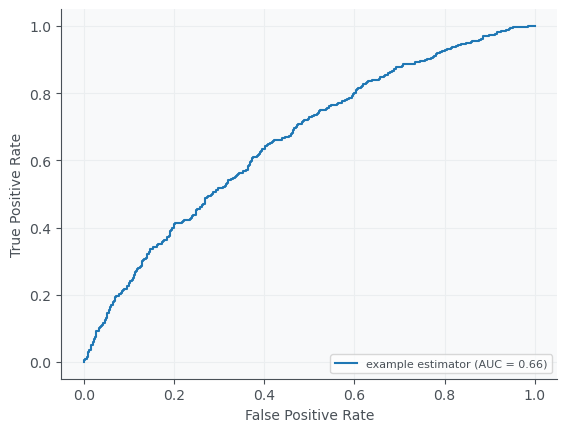

In [102]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(trues, probs)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()